# Class

0: head

1: helmet

2: face

3: mask

4: helmet & mask

# Validation

In [40]:
import os
import time
import cv2
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import accuracy_score
import yaml

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Classfication

In [2]:
def crop_and_classify(img, boxes, classification_model, transform):
    # classification_model.to(device)
    # classification_model.eval()
    
    for box in boxes:
        x1, y1, x2, y2 = box
        # Expand the bounding box by 10%
        width = x2 - x1
        height = y2 - y1
        x1 = max(int(x1 - 0.1 * width), 0)
        y1 = max(int(y1 - 0.1 * height), 0)
        x2 = min(int(x2 + 0.1 * width), img.shape[1] - 1)
        y2 = min(int(y2 + 0.1 * height), img.shape[0] - 1)

        # Crop the image
        cropped_img = img[y1:y2, x1:x2]

        # Transform the image to fit the input size of the classification model
        transformed_img = transform(cropped_img)
        transformed_img = transformed_img.unsqueeze(0)

        # Classify the cropped image
        with torch.no_grad():
            outputs = classification_model(transformed_img)
            _, predicted = torch.max(outputs.data, 1)
            confidence = torch.nn.functional.softmax(outputs, dim=1)[0][predicted].item()

        # Print the classification result
        print(f"Class: {predicted.item()}, Confidence: {confidence:.2f}")

        # Draw the bounding box and classification result on the image
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"Class: {predicted.item()}, Confidence: {confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
    return img

# Detection

In [3]:
def run_detection_model(img, model_detect):
    # img = transforms.ToTensor()(img).unsqueeze(0).to(device)  # Convert image to tensor and add batch dimension
    # model_detect.eval()  # Set model to evaluation mode
    img = transforms.ToTensor()(img).unsqueeze(0)
    
    # Move the model to the GPU
    model_detect = model_detect.to(device)

    # Run inference
    with torch.no_grad():
        detections = model_detect(img)

    # Extract bounding boxes and confidence scores
    boxes = detections.pred[0][:, :4].cpu().numpy().tolist()
    scores = detections.pred[0][:, 4].cpu().numpy().tolist()

    return boxes, scores


# Load detection model

In [4]:
weights_detect = "C:/Users/pinb/Desktop/pytorch/yolov5/runs/train/dduk_64_/weights/best.pt"
model_detect = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_detect)
model_detect = model_detect.to(device).eval()

Using cache found in C:\Users\pinb/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-12 Python-3.10.9 torch-1.12.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


# Load classification model

In [5]:
weights_cls = "C:/Users/pinb/Desktop/pytorch/yolov5/runs/train-cls/dduk_cls3/weights/best.pt"
model_cls = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_cls)
model_cls = model_cls.to(device).eval()


Using cache found in C:\Users\pinb/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-12 Python-3.10.9 torch-1.12.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)

Fusing layers... 
Model summary: 117 layers, 4173093 parameters, 0 gradients, 10.4 GFLOPs
WARNING  YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


# Load YAML

In [6]:
# # YAML 파일 경로
yaml_path = "C:/Users/pinb/Desktop/pytorch/yolov5/runs/detect/test/data.yaml"

def read_dataset_paths(file_path):
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
    test_path = data.get('test')
    train_path = data.get('train')
    val_path = data.get('val')
 
    return  os.path.join(os.path.dirname(file_path), val_path)

# # YAML 파일에서 데이터셋 경로 읽기
val_path = read_dataset_paths(yaml_path)

# 이미지가 있는 폴더 경로
folder_path = val_path
result_path = os.path.join(folder_path, "result")
# folder_path = "C:/Users/pinb/Desktop/pytorch/yolov5/runs/detect/test/"
# result_path = "C:/Users/pinb/Desktop/pytorch/yolov5/runs/detect/test/result"

def get_image_and_label_paths(folder_path):
    image_paths = []
    label_paths = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".bmp") or file_name.endswith(".jpg") or file_name.endswith(".png"):
            image_path = os.path.join(folder_path, file_name)
            image_paths.append(image_path)
            file_name = os.path.splitext(file_name)[0] + ".txt"
            label_path = folder_path.replace("images", "labels")
            label_path = os.path.join(label_path, file_name)
            if os.path.exists(label_path):
                label_paths.append(label_path)
            else:
                label_paths.append("")

    return image_paths, label_paths

# 폴더 내의 이미지 파일 경로들을 가져옴
image_paths, label_paths = get_image_and_label_paths(folder_path)

if not os.path.exists(result_path):
    os.makedirs(result_path)

# Read Label Data

In [7]:
def read_label(label_path):
    labels = []
    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            label = line.strip().split(' ')
            label_class = int(label[0])
            bounding_box = tuple(map(float, label[1:]))
            labels.append((label_class, bounding_box))
    return labels

# Find closet label class

In [8]:
def find_closest_label_class(pred_box, labels):
    min_distance = float('inf')
    closest_class = -1

    for i, label in enumerate(labels):
        label_box = label[1]
        label_center_x = (label_box[0] + label_box[2]) / 2
        label_center_y = (label_box[1] + label_box[3]) / 2

        pred_center_x = (pred_box[0] + pred_box[2]) / 2
        pred_center_y = (pred_box[1] + pred_box[3]) / 2

        distance = math.sqrt((label_center_x - pred_center_x) ** 2 + (label_center_y - pred_center_y) ** 2)

        if distance < min_distance:
            min_distance = distance
            closest_class = label[0]

    return closest_class

# Evaluate

In [9]:
lst_result = [[],[],[],[],[]] # class 0~4
eval_times = []

def Evaluate(model_detect, model_cls, img, img_name, labels, output=True):
    height, width, _ = img.shape
    expand_ratio = 0.5  # The ratio to expand the ROI area

    # Inference detection model
    start_time = time.time()
    results = model_detect(img)

    # For each detection, crop the ROI and classify it
    for *box, detect_conf, cls in results.xyxy[0]:
        x1, y1, x2, y2 = map(int, box)
        fbox = map(float, box)

        # Calculate the width and height of the bounding box
        bbox_width = x2 - x1
        bbox_height = y2 - y1
        roi = (x1, y1, bbox_width, bbox_height)

        # Calculate the expanded coordinates
        x1_expanded = max(0, x1 - int(bbox_width * expand_ratio))
        y1_expanded = max(0, y1 - int(bbox_height * expand_ratio))
        x2_expanded = min(width, x2 + int(bbox_width * expand_ratio))
        y2_expanded = min(height, y2 + int(bbox_height * expand_ratio))

        roi_flat = (x1_expanded, 
                    y1_expanded, 
                    bbox_width + int(bbox_width * expand_ratio) * 2, 
                    bbox_height + int(bbox_height * expand_ratio) * 2)

        # Crop the expanded ROI from the image
        # roi = img[y1:y2, x1:x2]
        roi_expanded = img.copy()
        roi_expanded = roi_expanded[y1_expanded:y2_expanded, x1_expanded:x2_expanded]
        roi_expanded = cv2.resize(roi_expanded, (224, 224))

        # Convert numpy array to torch tensor, and normalize pixel values
        roi_expanded = torch.from_numpy(roi_expanded).float().div(255.0)

        # Reshape tensor to (channels, height, width)
        roi_expanded = roi_expanded.permute(2, 0, 1)

        # Add an extra dimension for the batch
        roi_expanded = roi_expanded.unsqueeze(0)

        # Move roi_expanded to the same device as class_model
        roi_expanded = roi_expanded.to(device)
        class_result = model_cls(roi_expanded)

        # classfication result
        probabilities = F.softmax(class_result, dim=1)
        max_confidence, max_indices = torch.max(probabilities, dim=1)
        class_pred = max_indices.item()
        class_conf = max_confidence.item()

        # confidence
        total_conf = (detect_conf + class_conf) * 0.5

        # label - class
        class_gt = find_closest_label_class((x1, y1, x2, y2), labels)

        # append (class, confidence, bounding box)
        lst_result[class_pred].append((class_pred, class_gt, total_conf, (x1, y1, x2, y2)))

        # Put classification result on each ROI
        thin = 1
        color = ()
        if class_pred == 0: # head
            color = (0, 0, 255)
        elif class_pred == 1: # helmet
            color = (255, 0, 0)
        elif class_pred == 2: # face
            color = (0, 255, 0)
        elif class_pred == 3: # mask
            color = (255, 0, 255)
        elif class_pred == 4: # helmet & mask
            color = (255, 255, 0)
        cv2.putText(img, f'{class_pred}: {total_conf}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thin)
        # cv2.rectangle(img, roi_flat, color, thin)
        cv2.rectangle(img, roi, color, thin)
        if output is True:
            print(f'{img_name}\'s det + cls result [{class_pred}]: {total_conf}%, {roi}:')

    end_time = time.time()
    total_time = end_time - start_time
    eval_times.append(total_time)
    if output is True:
        print(f'Detect + Classfication Time: {total_time}s')

    # Save image
    cv2.imwrite(f'{result_path}/{img_name}_rst.jpg', img)


# Compare Ground Truth & Bounding Box

In [10]:
# Class
# 0: head
# 1: helmet
# 2: face
# 3: mask
# 4: helmet & mask

def CompareClass(pr, gt):
    if gt == 0: # head or face
        if pr == 0 or pr == 2:
            return True
        else:
            False
    elif gt == 1: # helmet or mask
        if pr == 1 or pr == 3 or pr == 4:
            return True
        else:
            return False

In [57]:
def CompareGTandBox(predict, setting_mAP=0):
    # 0: mAP@.5, 1: mAP@.5:.95 0
    # 비교하여 TP와 FP 구분
    results = []

    tp_cnt = 0
    fp_cnt = 0
    totalbox_cnt = 0
    targetbox_cnt = len(predict)

    for p_class, gt_class, confidence, p_box in predict:
        if CompareClass(p_class, gt_class):
            # iou = calculate_iou(p_box, l_box)
            # iou = confidence
            if setting_mAP == 0: # mAP@.5
                if confidence >= 0.5:
                    # True Positive (TP)
                    tp_cnt = tp_cnt + 1
                    totalbox_cnt = totalbox_cnt +1
                    # class, confidence, boudingbox, TP/FP, precision, recall
                    results.append((p_class, confidence, p_box, True, tp_cnt/totalbox_cnt, tp_cnt/targetbox_cnt))
            elif setting_mAP == 1: # mAP@.5:.95
                if confidence >= 0.5 and confidence < 0.95:
                    # True Positive (TP)
                    tp_cnt = tp_cnt + 1
                    totalbox_cnt = totalbox_cnt + 1
                    # class, confidence, boudingbox, TP/FP, precision, recall
                    results.append((p_class, confidence, p_box, True, tp_cnt/totalbox_cnt, tp_cnt/targetbox_cnt))
            else: # all P, R
                tp_cnt = tp_cnt + 1
                totalbox_cnt = totalbox_cnt + 1
                results.append((p_class, confidence, p_box, True, tp_cnt/totalbox_cnt, tp_cnt/targetbox_cnt))
            
        else:
            # False Positive (FP)
            totalbox_cnt = totalbox_cnt + 1
            results.append((p_class, confidence, p_box, False, tp_cnt/totalbox_cnt, tp_cnt/targetbox_cnt))

    return results

# Get Precisions, Recalls and PR Curve

In [43]:
def GetPR(results):
    results = sorted(results, key=lambda x: x[5], reverse=True)
    # results = sorted(results, key=lambda x: x[1], reverse=True)
    precisions = [item[4] for item in results]
    recalls = [item[5] for item in results]

    return precisions, recalls

# Calculate AP

In [55]:
def calculate_AP(precisions, recalls):
    assert len(recalls) == len(precisions)

    sorted_indices = sorted(range(len(recalls)), key=lambda i: recalls[i])
    sorted_precisions = [precisions[i] for i in sorted_indices]
    sorted_recalls = [recalls[i] for i in sorted_indices]

    ap = 0
    for i in range(1, len(sorted_recalls)):
        recall_diff = sorted_recalls[i] - sorted_recalls[i-1]
        ap += recall_diff * (sorted_precisions[i] + sorted_precisions[i-1]) * 0.5

    return ap

# Run

Class 0
meanP: 0.2451500387154128
meanR: 0.1266693073789041
AP@.5: 0.056300405455419165
AP@.5:.95: 0.056300405455419165

Class 1
meanP: 0.8831870385742567
meanR: 0.43243055555555554
AP@.5: 0.6344911937169155
AP@.5:.95: 0.6344911937169155

Class 2
meanP: 0
meanR: 0
AP@.5: 0
AP@.5:.95: 0

Class 3
meanP: 0.8349450369473351
meanR: 0.40800165622897366
AP@.5: 0.591933273620593
AP@.5:.95: 0.591933273620593

Class 4
meanP: 0.8888927177286716
meanR: 0.43473958333333357
AP@.5: 0.727062010345605
AP@.5:.95: 0.727062010345605



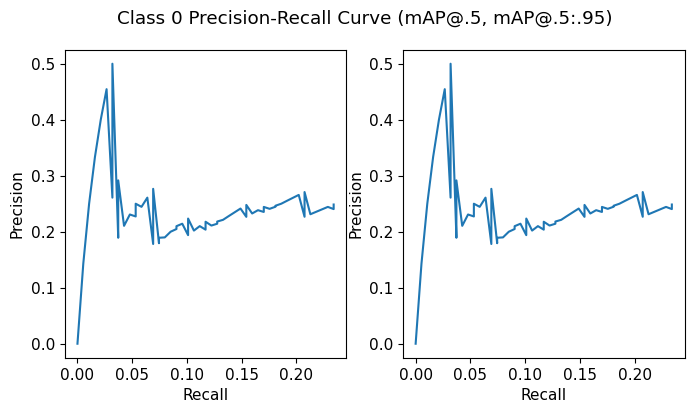

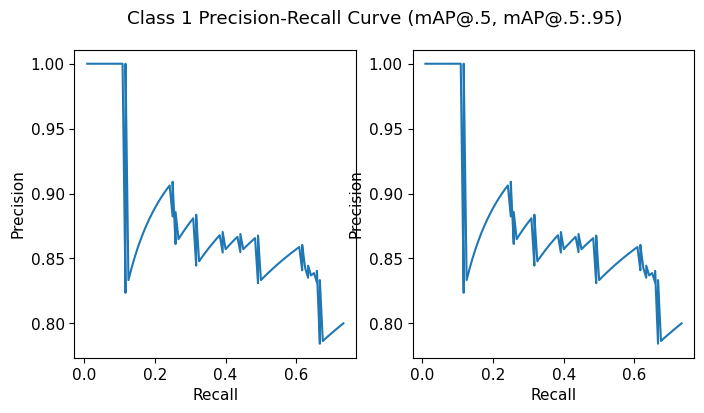

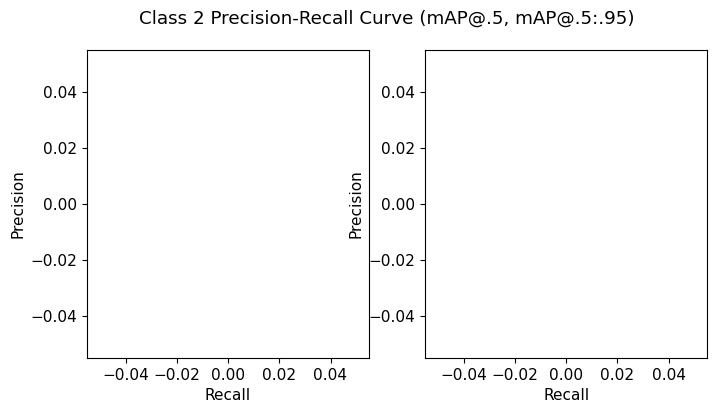

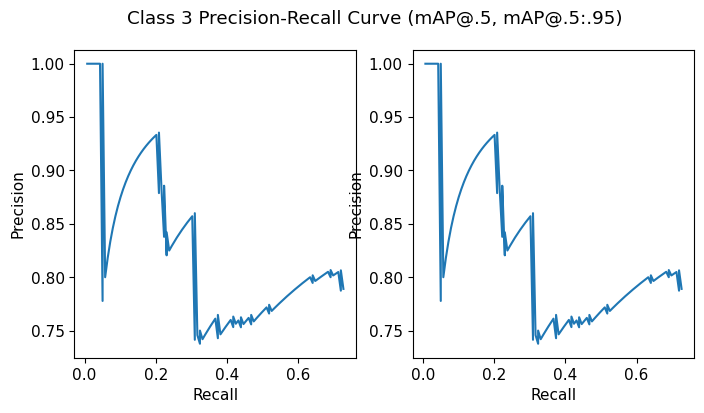

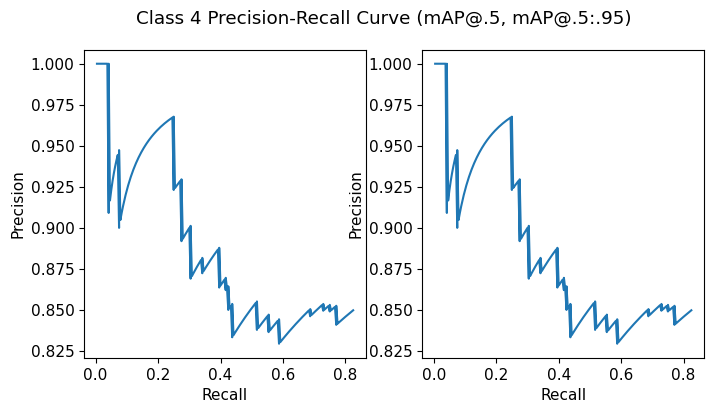

==> Union Model (Detection + Classification) - 5 classes
[mean Precisions] 0.5704349663931353
[mean Recalls] 0.2803682204993534
[mAP@.5] 0.40195737662770653
[mAP@.5:.95] 0.40195737662770653
[mean time] 0.042649137104018055s

==> Convert to Model 1
[mean Precisions] 0.6230357850195234
[mean Recalls] 0.3059043619902019
[mAP@.5] 0.4484272475282988
[mAP@.5:.95] 0.4484272475282988
[mean time] 0.042649137104018055s

==> Convert to Model 2
[mean Precisions] 0.6190156182172799
[mean Recalls] 0.30386862037965345
[mAP@.5] 0.3349644805230888
[mAP@.5:.95] 0.8897615083738772
[mean time] 0.042649137104018055s



In [63]:
lst_result = [[],[],[],[],[]] # class 0~4
eval_times = []

for i in range(0, len(image_paths)):
    # Image name
    img_dir = os.path.dirname(image_paths[i])
    img_name = os.path.basename(image_paths[i])

    # Load image
    img = cv2.imread(image_paths[i]) 
    img = cv2.resize(img, (640, 640))
    labels = read_label(label_paths[i])
    Evaluate(model_detect, model_cls, img, img_name, labels, False)

Ps = []
Rs = []
ap5s = []
ap95s = []

# Class
# 0: head
# 1: helmet
# 2: face
# 3: mask
# 4: helmet & mask

# each class result
class_len = len(lst_result)

for i in range(0, class_len): 
    results_all = CompareGTandBox(lst_result[i], -1) # all P, R
    results_5 = CompareGTandBox(lst_result[i], 0) # mAP@.5
    results_95 = CompareGTandBox(lst_result[i], 1) # mAP@.5:.95

    p, r = GetPR(results_all)
    p1, r1 = GetPR(results_5)
    p2, r2 = GetPR(results_95)
    ap1 = calculate_AP(p1, r1)
    ap2 = calculate_AP(p2, r2)
    # print(p1)
    # print(r1)
    # print(p2)
    # print(r2)
    if len(p) != 0:
        p = sum(p) / len(p)
    else:
        p = 0
    if len(r) != 0:
        r = sum(r) / len(r)
    else:
        r = 0

    Ps.append(p)
    Rs.append(r)
    ap5s.append(ap1)
    ap95s.append(ap2)
    print(f'Class {i}')
    print(f'meanP:', p)
    print(f'meanR:', r)
    print(f"AP@.5:", ap1)
    print(f"AP@.5:.95:", ap2)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].plot(r1, p1)
    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[1].plot(r2, p2)
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    plt.suptitle(f'Class {i} Precision-Recall Curve (mAP@.5, mAP@.5:.95)')
    print()
    
# plt.tight_layout()
plt.show()

mP = sum(Ps) / class_len
mR = sum(Rs) / class_len
mAP_5 = sum(ap5s) / class_len
mAP_95 = sum(ap95s) / class_len
mean_time = sum(eval_times) / len(eval_times)

print(f'==> Union Model (Detection + Classification) - 5 classes')
print(f'[mean Precisions] {mP}')
print(f'[mean Recalls] {mR}')
print(f'[mAP@.5] {mAP_5}')
print(f'[mAP@.5:.95] {mAP_95}')
print(f'[mean time] {mean_time}s')
print()


#### Convert to evaluate ####

# Class
# 0: head
# 1: helmet
# 2: face
# 3: mask
# 4: helmet & mask

# => Model 1: (0, 2, 3) - head, (1, 4) - helmet 
# => Model 2: (0, 1, 2) - face, (3, 4) - mask 

print(f'==> Convert to Model 1')
print(f'[mean Precisions] {((Ps[0] + Ps[2] + Ps[3]) / 3 + (Ps[1] + Ps[4]) / 2) / 2}')
print(f'[mean Recalls] {((Rs[0] + Rs[2] + Rs[3]) / 3 + (Rs[1] + Rs[4]) / 2) / 2}')
print(f'[mAP@.5] {((ap5s[0] + ap5s[2] + ap5s[3]) / 3 + (ap5s[1] + ap5s[4]) / 2) / 2}')
print(f'[mAP@.5:.95] {((ap95s[0] + ap95s[2] + ap95s[3]) / 3 + (ap95s[1] + ap95s[4]) / 2) / 2}')
print(f'[mean time] {mean_time}s')
print()

print(f'==> Convert to Model 2')
print(f'[mean Precisions] {((Ps[0] + Ps[1] + Ps[2]) / 3 + (Ps[3] + Ps[4]) / 2) / 2}')
print(f'[mean Recalls] {((Rs[0] + Rs[1] + Rs[2]) / 3 + (Rs[3] + Rs[4]) / 2) / 2}')
print(f'[mAP@.5] {((ap5s[0] + ap5s[1] + ap5s[2]) / 3 + (ap5s[3] + ap5s[4]) / 3) / 2}')
print(f'[mAP@.5:.95] {((ap95s[0] + ap95s[1] + ap95s[2]) / 3 + (ap95s[3] + ap95s[4]) / 2)}')
print(f'[mean time] {mean_time}s')
print()
